# Лабораторная работа №1 - Подготовка данных и кластеризация

## 1 - импорты библиотек

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from matplotlib import rcParams
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

warnings.simplefilter('ignore')

## 2 - импорт наборов данных

In [2]:
train = pd.read_csv("~/AI/titanic/train.csv")
test = pd.read_csv("~/AI/titanic/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3 - убираем данные, которые не имеют силы для вычисления выживших/погибших

In [3]:
train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


## 4 - закодируем данные категориальных меток

In [4]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [5]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [6]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [7]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
train['Sex'] = train['Sex'].replace({'female':0, 'male':1})
train['Embarked'].replace(to_replace={'S' : 0, 'C': 1, 'Q': 2}, inplace=True)
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,0.0
1,1,1,0,38.0,1,0,71.2833,1.0
2,1,3,0,26.0,0,0,7.9250,0.0
3,1,1,0,35.0,1,0,53.1000,0.0
4,0,3,1,35.0,0,0,8.0500,0.0
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,0.0
887,1,1,0,19.0,0,0,30.0000,0.0
888,0,3,0,NaN,1,2,23.4500,0.0
889,1,1,1,26.0,0,0,30.0000,1.0


## 4 - заполним пропуски в наборе данных

In [9]:
train.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,0.362205
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.636157
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


In [10]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [11]:
train.loc[train.Age.isnull(), 'Age'] = train['Age'].median()
train['Age'].describe()

count    891.000000
mean      29.361582
std       13.019697
min        0.420000
25%       22.000000
50%       28.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

In [12]:
train[train['Embarked'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,0,38.0,0,0,80.0,NaN
829,1,1,0,62.0,0,0,80.0,NaN


In [13]:
train.fillna(0)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,0.0
1,1,1,0,38.0,1,0,71.2833,1.0
2,1,3,0,26.0,0,0,7.9250,0.0
3,1,1,0,35.0,1,0,53.1000,0.0
4,0,3,1,35.0,0,0,8.0500,0.0
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,0.0
887,1,1,0,19.0,0,0,30.0000,0.0
888,0,3,0,28.0,1,2,23.4500,0.0
889,1,1,1,26.0,0,0,30.0000,1.0


In [14]:
train.shape

(891, 8)

## 5 - Графики

## количественное соотношение по полу на корабле

Sex
0    314
1    577
dtype: int64
0 - Female, 1 - Male


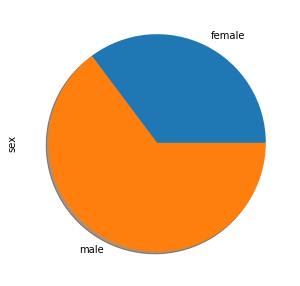

In [15]:
new_df = train.groupby('Sex').size()
print(new_df)
print("0 - Female, 1 - Male")
plot = new_df.plot.pie(x='Sex', figsize=(5, 5), labels=['female','male'], label='sex',shadow=True )

## выжившие, в зависимости от пола.

In [16]:
df_counts = train.groupby(['Sex','Survived']).size().reset_index(name='counts')
df_counts['Sex'] = df_counts['Sex'].replace({0:'Female', 1:'Male'})
df_counts['Survived'] = df_counts['Survived'].replace({0:'No', 1:'Survived'})
df_counts

,Sex,Survived,counts
0,Female,No,81
1,Female,Survived,233
2,Male,No,468
3,Male,Survived,109


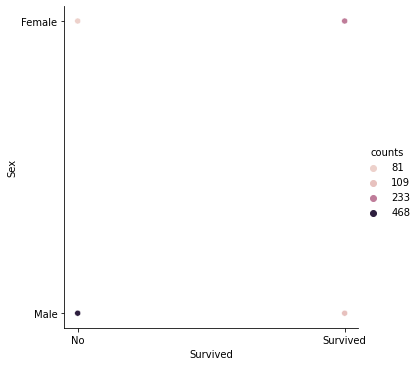

In [17]:
sns.relplot(
    data=df_counts,
    x='Survived',
    y='Sex',
    hue='counts')

## распределение по возрасту на корабле

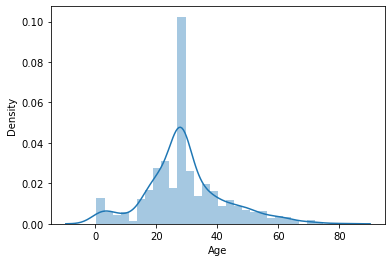

In [18]:
fig = sns.distplot(train.Age)

In [19]:
new_df = train.groupby(['Age','Survived']).size().reset_index(name='counts')
new_df = pd.cut(new_df['Age'], bins=[0,10,20,30,40,50,60,70,80])
new_df = pd.crosstab(new_df, train['Survived'])
new_df = new_df.rename(columns={1: 'Выжил', 0: 'Мертв'})
new_df

Survived,Мертв,Выжил
Age,,
"(0, 10]",11,12
"(10, 20]",12,7
"(20, 30]",14,10
"(30, 40]",15,10
"(40, 50]",16,5
"(50, 60]",14,4
"(60, 70]",6,2
"(70, 80]",3,1


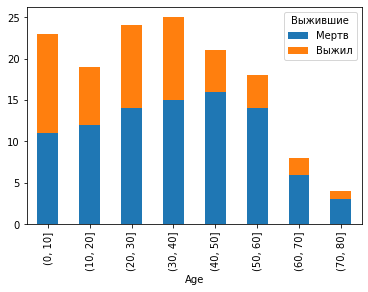

In [20]:
new_df.plot.bar(stacked=True)
plt.legend(title='Выжившие')
plt.show()

## 6 - Уберем выбросы

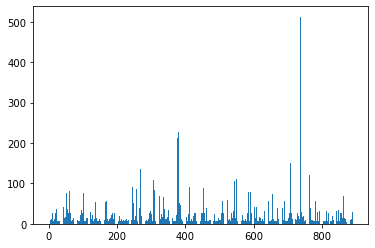

In [21]:
ind = np.arange(train['Fare'].count())
plt.bar(ind, train['Fare'])
plt.show()

In [22]:
train[train['Fare'] > 300]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
258,1,1,0,35.0,0,0,512.3292,1.0
679,1,1,1,36.0,0,1,512.3292,1.0
737,1,1,1,35.0,0,0,512.3292,1.0


In [23]:
mean_fare_for_1_class = train[(train['Fare'] < 300) & (train['Pclass'] == 1)]['Fare'].mean()
mean_fare_for_1_class
train.loc[train['Fare'] > 300, 'Fare'] = mean_fare_for_1_class
mean_fare_for_1_class

78.1240605633802

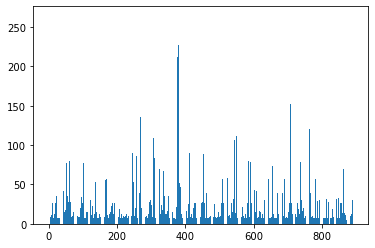

In [24]:
plt.bar(ind, train['Fare'])
plt.show()

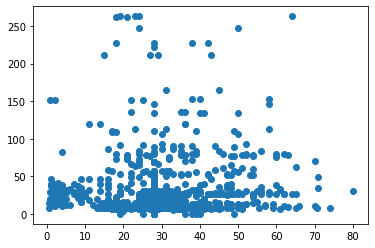

In [25]:
plt.scatter(train['Age'], train['Fare'])
plt.show()

## 7 - Сформируем новые данные исходя из имеющихся

In [26]:
train['Relatives'] = train['SibSp'] + train['Parch']
train[['SibSp', 'Parch', 'Relatives']].head(10).tail(5)

,SibSp,Parch,Relatives
5,0,0,0
6,0,0,0
7,3,1,4
8,0,2,2
9,1,0,1


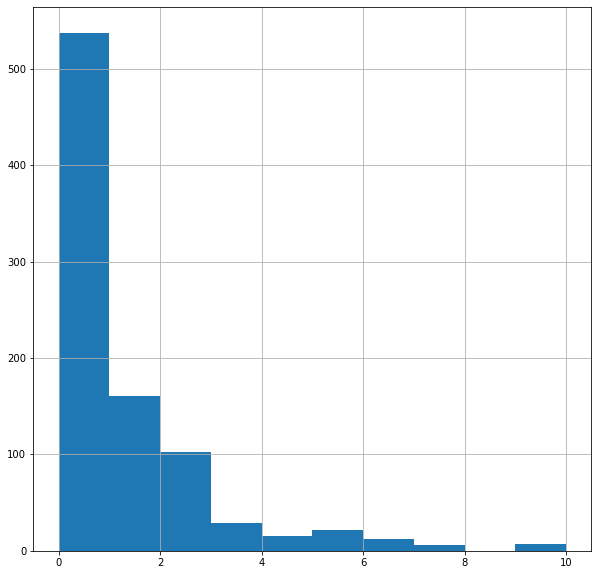

In [27]:
train['Relatives'].hist(figsize=[10, 10])
plt.show()

In [28]:
train.loc[train['Relatives'] > 0, 'Relatives_binary'] = 1
train.loc[train['Relatives_binary'].isnull(), 'Relatives_binary'] = 0
train[['Relatives', 'Relatives_binary']].head(10).tail(5)

,Relatives,Relatives_binary
5,0,0.0
6,0,0.0
7,4,1.0
8,2,1.0
9,1,1.0


In [29]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Relatives,Relatives_binary
0,0,3,1,22.0,1,0,7.2500,0.0,1,1.0
1,1,1,0,38.0,1,0,71.2833,1.0,1,1.0
2,1,3,0,26.0,0,0,7.9250,0.0,0,0.0
3,1,1,0,35.0,1,0,53.1000,0.0,1,1.0
4,0,3,1,35.0,0,0,8.0500,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,0.0,0,0.0
887,1,1,0,19.0,0,0,30.0000,0.0,0,0.0
888,0,3,0,28.0,1,2,23.4500,0.0,3,1.0
889,1,1,1,26.0,0,0,30.0000,1.0,0,0.0


## 8 - нормализация 

In [30]:
quantitative = train[['Age', 'SibSp', 'Parch', 'Fare', 'Relatives']]
quantitative.head(5)

,Age,SibSp,Parch,Fare,Relatives
0,22.0,1,0,7.2500,1
1,38.0,1,0,71.2833,1
2,26.0,0,0,7.9250,0
3,35.0,1,0,53.1000,1
4,35.0,0,0,8.0500,0


In [31]:
X = quantitative.values
X

array([[22.    ,  1.    ,  0.    ,  7.25  ,  1.    ],
       [38.    ,  1.    ,  0.    , 71.2833,  1.    ],
       [26.    ,  0.    ,  0.    ,  7.925 ,  0.    ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ,  3.    ],
       [26.    ,  0.    ,  0.    , 30.    ,  0.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ,  0.    ]])

In [33]:
stand_scaler = StandardScaler().fit(X)
X_normalized = stand_scaler.transform(X)
X_normalized

array([[-0.56573646,  0.43279337, -0.47367361, -0.57053177,  0.05915988],
       [ 0.66386103,  0.43279337, -0.47367361,  0.984579  ,  0.05915988],
       [-0.25833709, -0.4745452 , -0.47367361, -0.55413874, -0.56097483],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, -0.17709907,  1.29942929],
       [-0.25833709, -0.4745452 , -0.47367361, -0.01802596, -0.56097483],
       [ 0.20276197, -0.4745452 , -0.47367361, -0.55838879, -0.56097483]])

## 9 - Осуществить сокращение размерности данных методом главных компонент

In [36]:
pca = PCA(n_components=2).fit(X_normalized)
X_reduced = pca.transform(X_normalized)
X_reduced

array([[ 0.00984319, -0.87012814],
       [ 0.12934432,  1.07795365],
       [-0.90830518, -0.55410731],
       ...,
       [ 1.99770267, -0.0944692 ],
       [-0.77868348, -0.18991272],
       [-1.00551822, -0.22262316]])

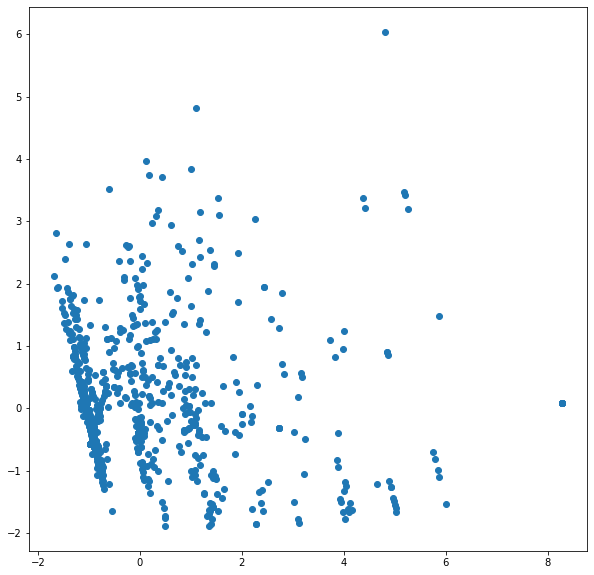

In [45]:
plt.figure(figsize=(10, 10))
plt.scatter(X_reduced[:,0], X_reduced[:,1])
plt.show()

## 10 - класстеризация

## иерархическая/ агломеративная кластеризация.

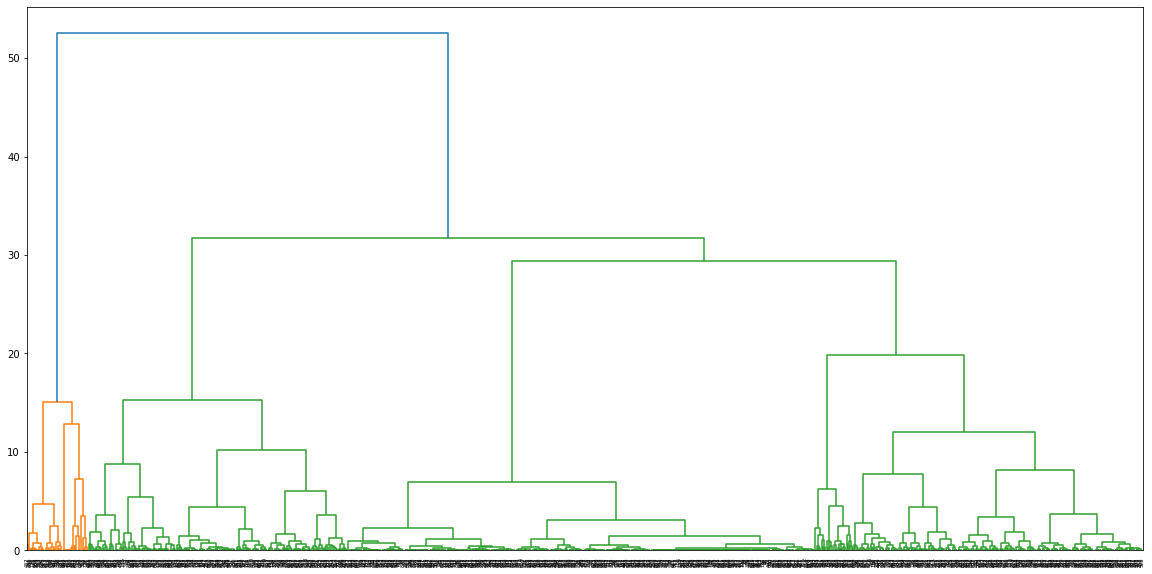

In [60]:
Z = linkage(X_reduced, method='ward', metric='euclidean')
plt.figure(figsize=(20, 10))
dn = dendrogram(Z)
plt.show()

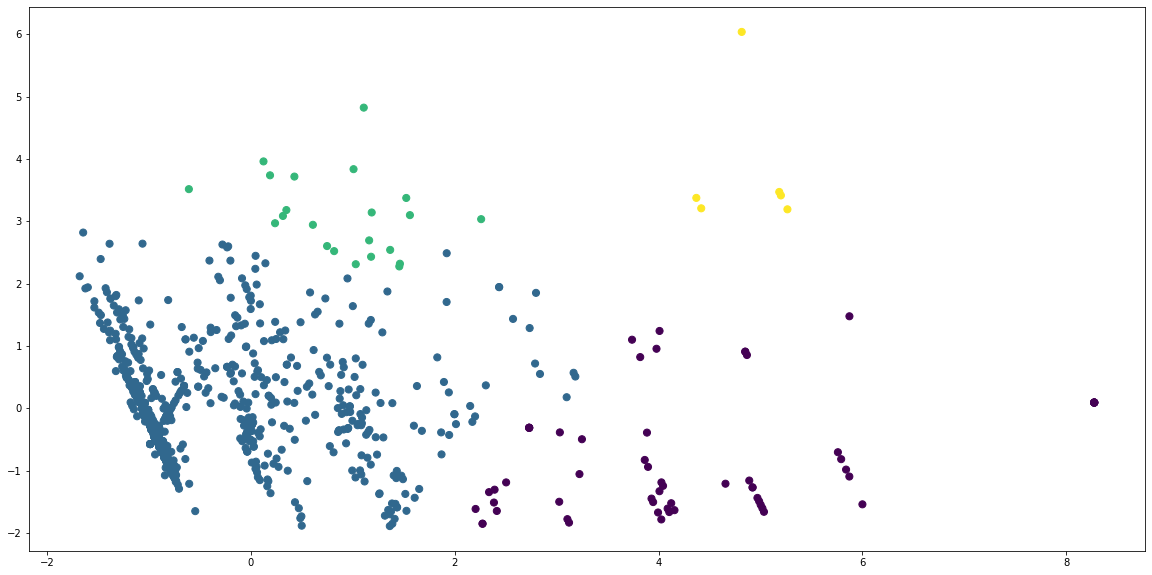

In [62]:
labels = AgglomerativeClustering(n_clusters=4, affinity='manhattan', linkage='complete').fit_predict(X_reduced)
plt.figure(figsize=(20, 10))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels, s=50)
plt.show()

In [64]:
silhouette_score(X_reduced, labels, metric='manhattan')

0.5443858993376648

согласно https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html affinity принимает значение только евклидовой метрики если linkage - ward (сводит к минимуму дисперсию обьединяемых классов)

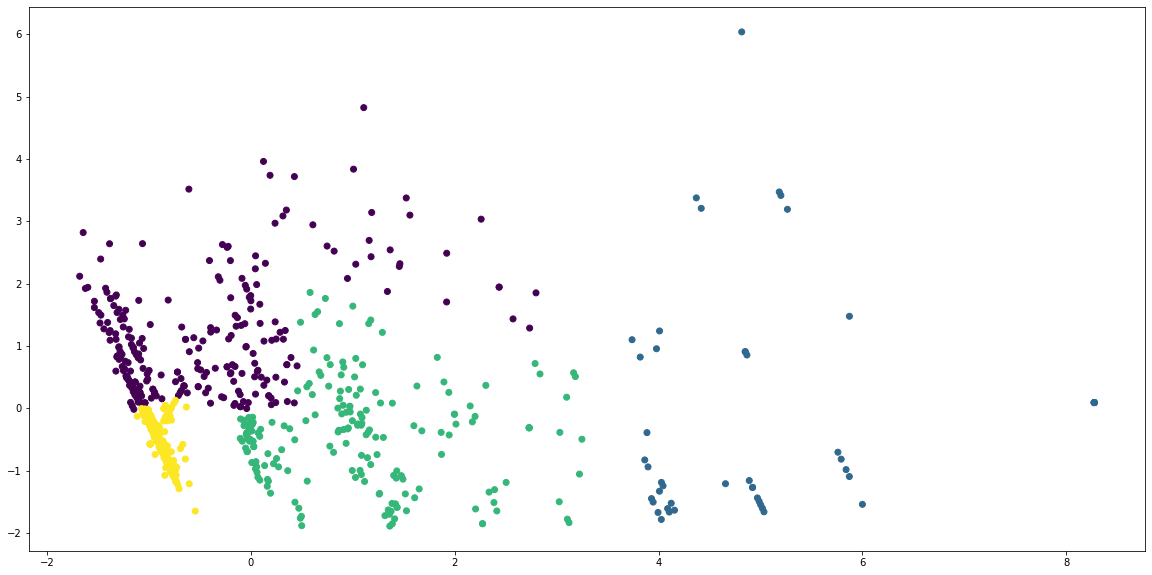

In [66]:
labels = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit_predict(X_reduced)
plt.figure(figsize=(20, 10))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels)
plt.show()

In [67]:
silhouette_score(X_reduced, labels, metric='euclidean')

0.413536064738831

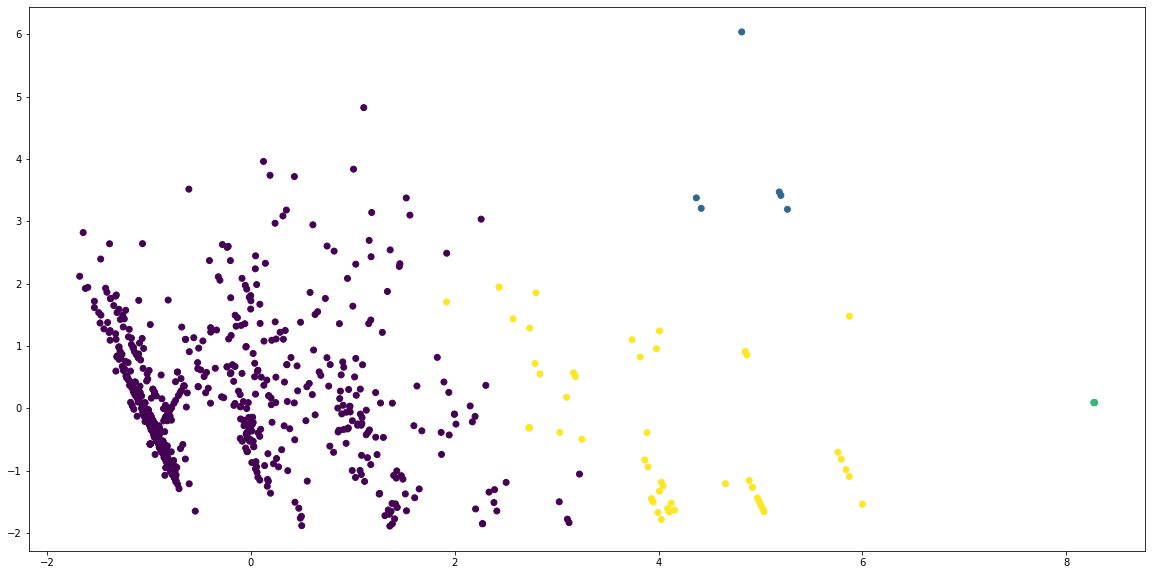

In [68]:
labels = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='average').fit_predict(X_reduced)
plt.figure(figsize=(20, 10))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels)
plt.show()

In [69]:
silhouette_score(X_reduced, labels, metric='euclidean')

0.6268707847906017